<a href="https://colab.research.google.com/github/akshithatirnathi05/fmml-cource/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5050 Acc: 0.7377

Epoch 1/4
----------
Loss: 0.4488 Acc: 0.8238

Epoch 2/4
----------
Loss: 0.5375 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.4730 Acc: 0.8197

Epoch 4/4
----------
Loss: 0.4090 Acc: 0.8402



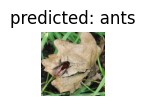

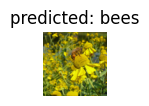

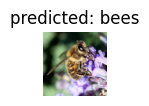

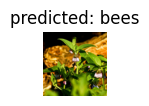

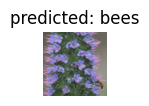

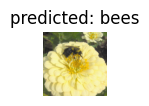

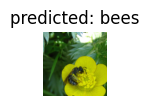

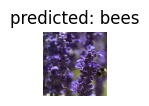

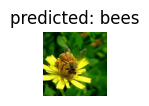

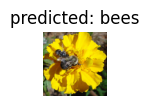

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


## ANSWERS

### 1. Significance of Using Data Augmentations Like Resize, Crop, etc., on Training Data

Data augmentation techniques, such as resizing and cropping, play a crucial role in enhancing the performance of machine learning models, especially in image processing tasks. Here’s why they are significant:

1. **Increase Data Diversity**: By augmenting the training data, we effectively increase the diversity of the dataset without the need to collect more data. This helps the model generalize better to new, unseen data by learning more robust features.

2. **Prevent Overfitting**: Augmentations like random cropping, flipping, rotation, and resizing introduce variations in the training images, preventing the model from memorizing the training data. This reduces overfitting and improves the model’s ability to generalize to new data.

3. **Simulate Real-World Variations**: Data augmentations can simulate real-world scenarios and variations that the model might encounter during deployment. This includes changes in object scale, orientation, and lighting conditions, which make the model more adaptable and resilient.

4. **Balance Data Distribution**: For imbalanced datasets, augmentations can help balance the distribution by generating more samples for underrepresented classes, thus helping the model to learn equally from all classes.

### 2. Performance Without Using Pretrained ResNet Model

Training a ResNet model from scratch (i.e., setting `pretrained=False`) generally results in significantly lower performance compared to using a pretrained model, especially when the dataset is small. Here are some reasons why:

1. **Lack of Prior Knowledge**: Pretrained models have already learned useful features from large datasets such as ImageNet. These features serve as a good starting point. Without this prior knowledge, the model has to learn all features from scratch, which is more challenging and time-consuming.

2. **Need for Larger Dataset**: Training a deep neural network like ResNet from scratch typically requires a very large dataset to avoid overfitting and to learn robust features. If the dataset is small, the model is likely to overfit and perform poorly on unseen data.

3. **Longer Training Time**: Training from scratch requires more computational resources and time because the model starts with randomly initialized weights and has to learn everything from the ground up.

### 3. Using a Pretrained ResNet Model on a Different Dataset

If the ResNet model was pretrained on a dataset significantly different from the ants vs bees data, its performance might still be good, but with some caveats:

1. **Transfer Learning**: Pretrained models are based on the principle of transfer learning, where the features learned from a large and diverse dataset can be transferred to a new task. Even if the pretrained dataset is different, many low-level features (like edges, textures, shapes) learned by the model are generally applicable to a wide range of image tasks.

2. **Fine-Tuning**: To adapt the pretrained model to the new dataset, fine-tuning the model is often necessary. This involves training the model on the new dataset with a lower learning rate to adjust the pretrained weights to better fit the new data while retaining the useful features learned previously.

3. **Domain Difference Impact**: The more similar the pretraining dataset is to the target dataset, the better the performance is likely to be. Significant differences in domains (e.g., medical images vs. natural images) may require more extensive fine-tuning and might not leverage the pretrained features as effectively.

In conclusion, using data augmentations improves model robustness and generalization, training from scratch typically yields poorer performance without large datasets, and pretrained models can still perform well on different datasets with appropriate fine-tuning.